In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:75% !important}</style>"))

# Project: Classification - Loan Eligibility Prediction

## Context: 
----------------

Credit risk is the risk of loss resulting from the failure by a borrower to repay the principal and interest owed to the lender. The lender uses the interest payments from the loan to compensate for the risk of potential losses. When the borrower defaults on his/her obligations, it causes an interruption in the cash flow of the lender.

In the banking sector, this is an important factor to be considered before approving the loan of an applicant in order to cushion the lender from loss of cash flow and reduce the severity of losses. 

------------------
## Objective:
------------------

Easy House is a finance company that deals in several varieties of home loans. They have a presence across urban, semi-urban, and rural areas. Currently, the customer first applies for a home loan post which the company validates the customer's eligibility for that loan. 

Now, the company wants to automate the loan eligibility process. They want to harness their past customers' data to build a model to predict whether the loan should be approved or not. This would help the company prevent potential losses, save time and focus more on eligible customers.

--------------------------
## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [3]:
data = pd.read_csv("CreditRisk.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360.0,1.0,Urban,1


#### Check the info of the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    int64  
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 62.5+ KB


**Observations:**

- There are 614 observations and 13 columns in the data.
- ApplicantIncome, CoapplicantIncome, Loan_Amount_Term, Credit_History, and Loan_Status are numeric data types. The rest of the variables are of the object data type.
- There are several columns with less than 614 non-null entries i.e. these columns have missing values.
- Loan_ID column is an identifier. Let's check if each entry of the column is unique.

In [5]:
data.Loan_ID.nunique()

614

- We can see that all the entries of this column are unique. Hence, this column would not add any value to our analysis. 
- Let's drop this column.

## Exploratory Data Analysis and Data Preprocessing

#### Dropping Loan_ID column

In [6]:
data.drop(columns=['Loan_ID'], inplace=True)

#### Summary Statistics for numerical columns

In [7]:
#Creating a list of numerical columns
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


# print summary statistics 
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,614.0,141.166124,88.340630,0.0,98.0,125.0,164.75,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0


**Observations:__________**
- Applicant Income and coapplicant Income both have high variation. This is indicative of the many different ranges of bank's customer's salaries.
- Loan Amount has a minimal value of 0. This could be an error or missing value for which 0 is a placeholder. Less than 50% of the customers ask for a loan of 125,000, with a maximum loan request of 700,000.
- Loan Amount Term appears to be inputted in days rather than months with the exception of the minimum value of 12. Which is assumed to be in months. 

- There are 22 observations with 0 as the loan amount
- There is no definite pattern. 
- This could be an error or missing loan amount information

In [14]:
data.query('LoanAmount == 0').head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,0,360.0,1.0,Urban,1
35,Male,Yes,0,Graduate,No,2275,2067.0,0,360.0,1.0,Urban,1
63,Male,Yes,1,Graduate,No,4945,0.0,0,360.0,0.0,Rural,0
81,Male,Yes,1,Graduate,Yes,2395,0.0,0,360.0,1.0,Semiurban,1
95,Male,No,0,Graduate,NaN,6782,0.0,0,360.0,NaN,Urban,0


#### Feature Engineering

In [17]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term'] = data.loc[data['Loan_Amount_Term'] != 12, 'Loan_Amount_Term'] / 12

In [23]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income'] = data['ApplicantIncome'] + data['CoapplicantIncome']

In [24]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

#### Check the distribution and outliers for each column in the data

LoanAmount
Skew : 2.36


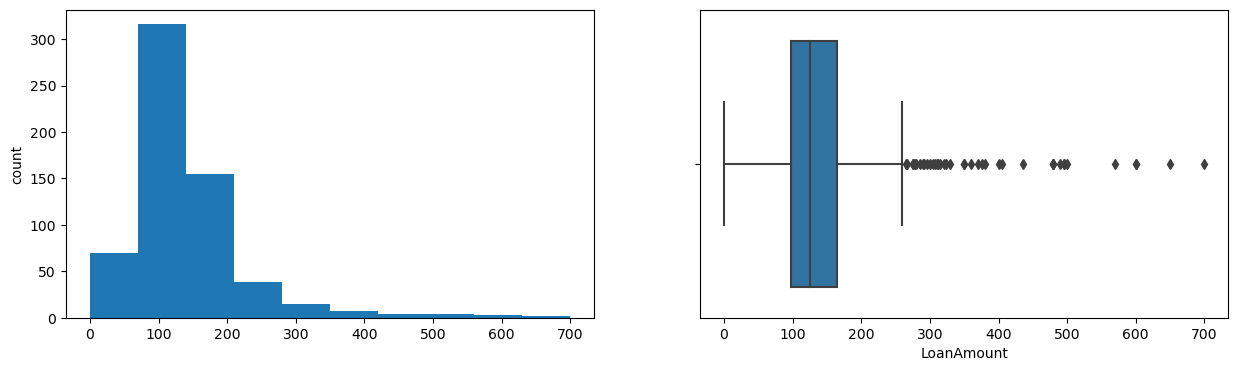

total_income
Skew : 5.63


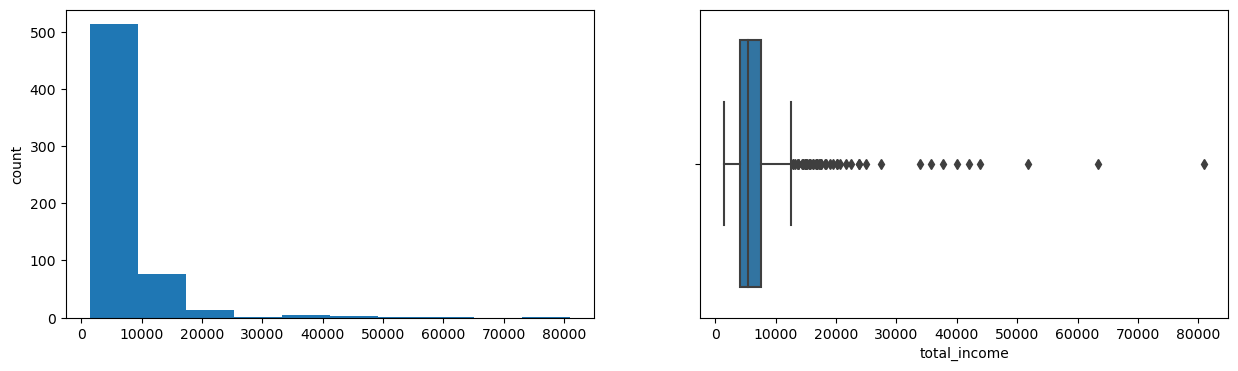

In [25]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observations:**

- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10K.

Not, let's check the percentage of observations in each category for all the categorical variables.

#### Checking percentage of each category for categorical variables

In [26]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize = True)) 
    print('*'*40)                                  #Print the * 40 times to separate different variables

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
1    0.687296
0    0.312704
Name: Loan_Status, dtype: float64
****************************************


**Observations:___________**
- The majority of loan applicants are male with a percentage of ~81%. The percentage of female applicants is ~19%. Due to missing values the percentages do not add up to 100.
- Majority of customers applying for loans are married with the married percentage rate at 65%.
- 75% of the applicants have 0 - 1 children which accounts for the majority of applicants. About 26% of applicants have 2 - 3 children.
- Most of the applicants are graduates. Graduate percentage, 78%.
- The majority of applicants; 86%, work normal jobs and are not self employed.
- 84% of the applicants have a credit history that meet required guidelines.
- The proportion of customers applying for a loan in a semi-urban and urban areas are closely matched at 38% and 33% respectfully. 29% of the applicants are applying for a home loan within the rural area.
- 69% of the loans applied for were approved while 31% of the loans applied where not approved.

#### Imputing missing values

In [27]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value = data[col].mode()[0], inplace=True)

In [28]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value = data.LoanAmount.median(), inplace = True)

**Now that we are done with the data preprocessing. Let's explore the data a bit more with bivariate analysis.**

Let's check the relationship of loan amount with the total income.

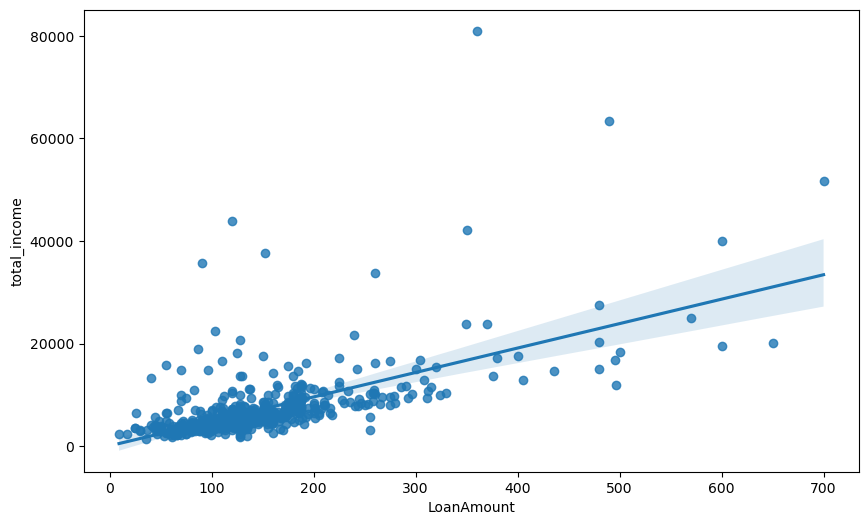

In [32]:
plt.figure(figsize=(10,6))
sns.regplot(x = 'LoanAmount', y = 'total_income', data = data)
plt.show()

- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relationship of total income with loan status

<AxesSubplot:xlabel='Loan_Status', ylabel='total_income'>

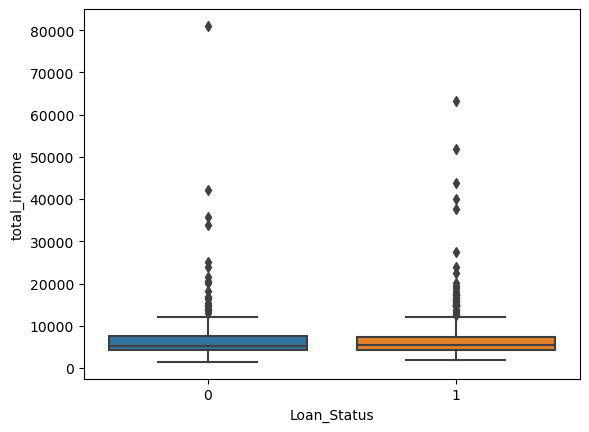

In [33]:
sns.boxplot(x = data.Loan_Status, y = data.total_income)

- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

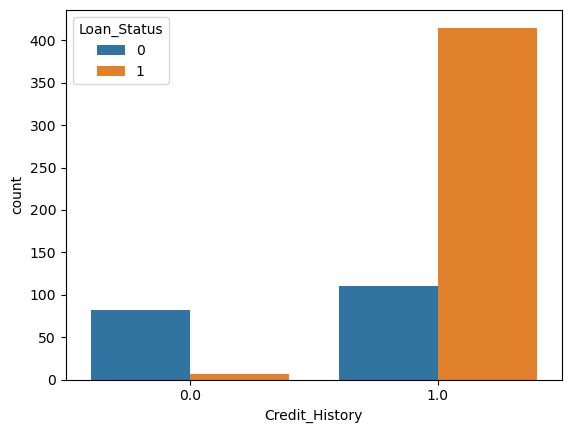

In [34]:
sns.countplot(x = data.Credit_History, hue = data.Loan_Status)

- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status

<AxesSubplot:xlabel='Education', ylabel='count'>

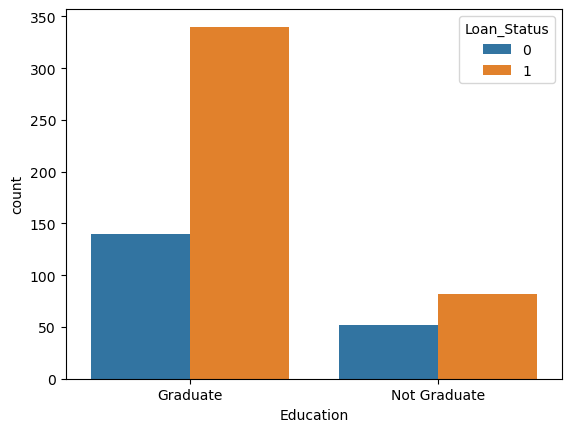

In [35]:
sns.countplot(x = data.Education, hue = data.Loan_Status)

- We can see that graduate customers are more likely to get loans.
- This might be because, in general, graduate customers have higher income when compared to non-graduates. Let's check if this is true.

<AxesSubplot:xlabel='Education', ylabel='total_income'>

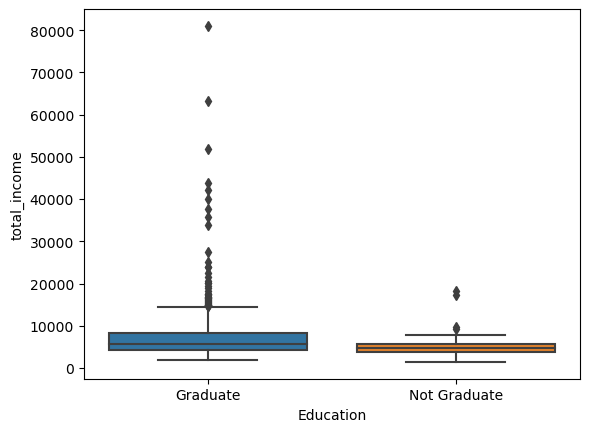

In [39]:
sns.boxplot(x = data.Education, y = data.total_income)

- We can see that this does appear to be true; graduate customers seem to earn more on average.

Let's check how property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

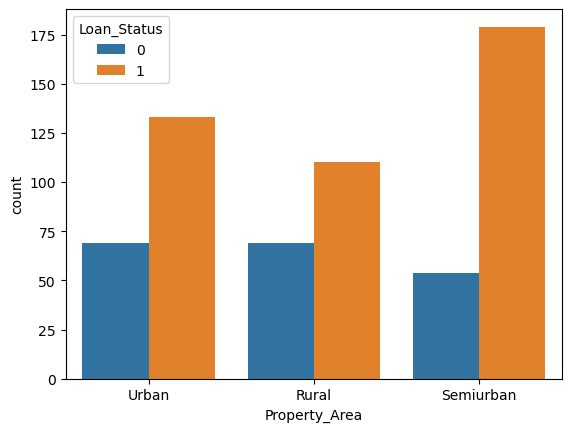

In [40]:
sns.countplot(x = data.Property_Area, hue = data.Loan_Status)

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

In [45]:
#Separating target variable and other variables

Y = data['Loan_Status']
X = data.drop(columns = 'Loan_Status')

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,total_income
0,Male,No,0,Graduate,No,128.0,30.0,1.0,Urban,5849.0
1,Male,Yes,1,Graduate,No,128.0,30.0,1.0,Rural,6091.0
2,Male,Yes,0,Graduate,Yes,66.0,30.0,1.0,Urban,3000.0
3,Male,Yes,0,Not Graduate,No,120.0,30.0,1.0,Urban,4941.0
4,Male,No,0,Graduate,No,141.0,30.0,1.0,Urban,6000.0


In [47]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

,LoanAmount,Loan_Amount_Term,Credit_History,total_income,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,128.0,30.0,1.0,5849.0,1,0,0,0,0,0,0,0,1
1,128.0,30.0,1.0,6091.0,1,1,1,0,0,0,0,0,0
2,66.0,30.0,1.0,3000.0,1,1,0,0,0,0,1,0,1
3,120.0,30.0,1.0,4941.0,1,1,0,0,0,1,0,0,1
4,141.0,30.0,1.0,6000.0,1,0,0,0,0,0,0,0,1


In [48]:
#Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1)

## Building Classification Models

# **Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

### Model evaluation criterion:

#### Since this is a binary classification problem, the model can make wrong predictions in one of two ways:
1. Predicting a customer is not eligible for a loan when the customer actually is eligible - Loss of opportunity
2. Predicting a customer is eligible for a loan when the customer is actually not - Financial loss

#### Which case is more important? 
* Predicting that the customer is eligible when he is not, because the person might default or not be able to return the loan, which would result in financial loss to the company.

#### How to reduce this loss i.e need to reduce False Negatives?
* In classification, the class of interest is considered the positive class. Here, the class of interest is 0 i.e. identifying non-eligible customers. So, the company wants to minimize the number of false negatives, in other words **Recall** is the evaluation criterion to be maximized.

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [49]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Logistic Regression

In [60]:
#define logistic regression model the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

**Let's check the coefficient of each dependent variable in the data**

In [61]:
pd.Series(log_reg.coef_[0], index = X_train.columns).sort_values(ascending = False)

Credit_History             3.032494
Property_Area_Semiurban    0.807252
Married_Yes                0.200392
Dependents_2               0.157395
Dependents_3+              0.115840
Property_Area_Urban        0.006261
total_income              -0.000009
LoanAmount                -0.000517
Loan_Amount_Term          -0.065164
Self_Employed_Yes         -0.101279
Gender_Male               -0.107284
Dependents_1              -0.146358
Education_Not Graduate    -0.495449
dtype: float64

**Observations:_________**
**Some features which positively affect eligibility**
- **Customers are more likely to be eligible if they possess these factors**
- Good credit history.
- A loan for a property in semiurban area.
- Are married
- Have children
- A loan for a property in urban area.
<br><br>

**Some features which negatively affect eligibility**
- **Customers are less likely to be eligible if they possess these factors**
- Low income
- Low loan amount and amount term
- If the customer is self employed
- If the customer is of male gender
- If the customer only has I child
- If the customer is not a graduate

#### Interpretations of the odds calculated from the logistic regression model coefficients 

In [57]:
odds = np.exp(log_reg.coef_[0]) #finding the odds

# adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,20.748912
Property_Area_Semiurban,2.241740
Married_Yes,1.221882
Dependents_2,1.170458
Dependents_3+,1.122816
Property_Area_Urban,1.006280
total_income,0.999991
LoanAmount,0.999483
Loan_Amount_Term,0.936914
Self_Employed_Yes,0.903681


**Observations:_____**
- The odds of a customer becoming eligible with a credit history which meets required guidelines is 20.7 time greater than that of a customer who doesn't meet the required guidelines.
- The odds of a customer being eligible for a loan in a semi-urban area is 2.24 times greater than a customer with in an urban area.
- The odds of a customer with 2 children of being eligible is 1.17 to customers who only have 1 child and customers with 3 children. For customers with 3 children the odds are 1.12 greater than those with a single child.

**Now, let's check the performance of the model on the training set**

#### Checking the performance on the training data 

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



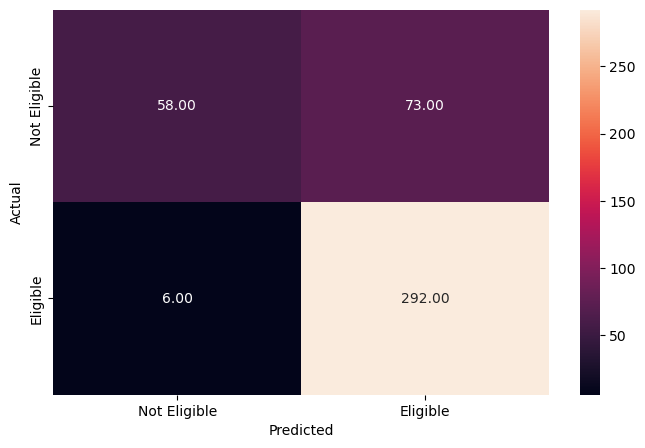

In [63]:
#predict on the training data 
y_pred_train = log_reg.predict(X_train)
metrics_score(y_train, y_pred_train)

# Checking performance on the training data
#metrics_score(y_test, y_pred_train)

**Reading confusion matrix (clockwise):**

- **True Positive**: Predicting the customer is not eligible and the customer is actually not eligible
- **False Negative**: Predicting the customer is eligible but the customer is actually not eligible
- **True Negative**: Predicting the customer is eligible and the customer is actually eligible
- **False Positive**: Predicting the customer is not eligible but the customer is actually eligible

**Observations:_____**
- The model accuracy is at 82%  on the train dataset. The model makes the correct prediction 82% of the time.
- Precision perform well for both class 0 and 1, with scores of 91% and 80% respectfully.
- Recall only performs well for class 1 and only has a performance of 44% for class 0. The model will not perform well in predicting customers who are not eligible out of all customers who are actually not eligible. Hence, this model will not save the company from significant financial loss.

**Precision-Recall Curve for Logistic Regression**

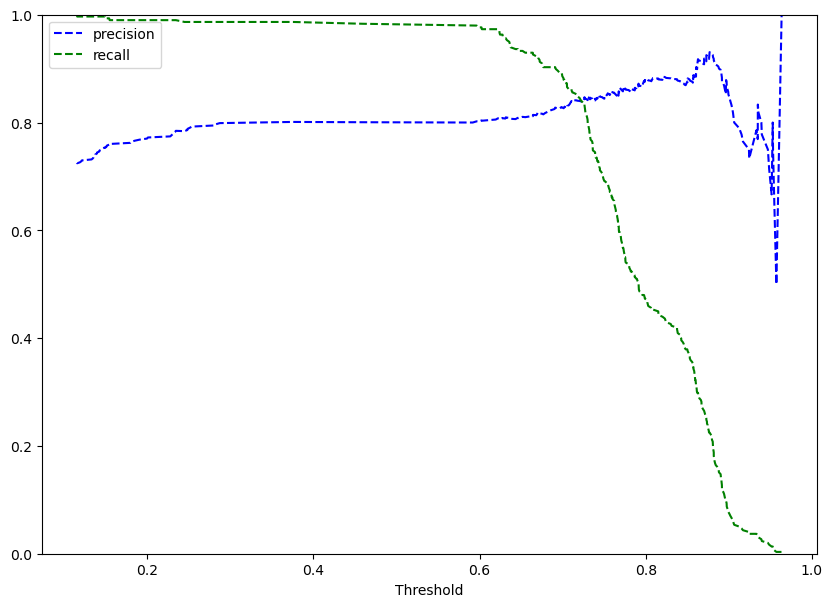

In [64]:
y_scores=log_reg.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [65]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i] == recalls[i]:
        print(thresholds[i])

0.7228053872429451


- The threshold of 0.72 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall.
- **Note:** We also don't want the precision to be so poor that it outweighs the benefits of a higher recall. 

#### Comparing the performance of the model on training and testing sets after changing the threshold

              precision    recall  f1-score   support

           0       0.50      0.71      0.59       131
           1       0.84      0.69      0.76       298

    accuracy                           0.70       429
   macro avg       0.67      0.70      0.67       429
weighted avg       0.74      0.70      0.71       429



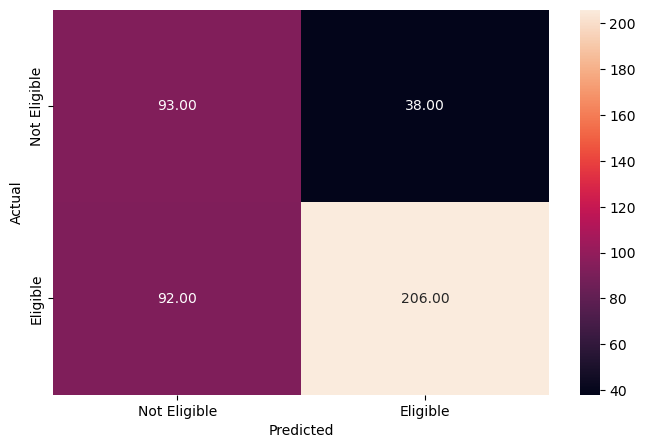

In [70]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1] > optimal_threshold1)

              precision    recall  f1-score   support

           0       0.56      0.66      0.60        61
           1       0.81      0.74      0.78       124

    accuracy                           0.71       185
   macro avg       0.68      0.70      0.69       185
weighted avg       0.73      0.71      0.72       185



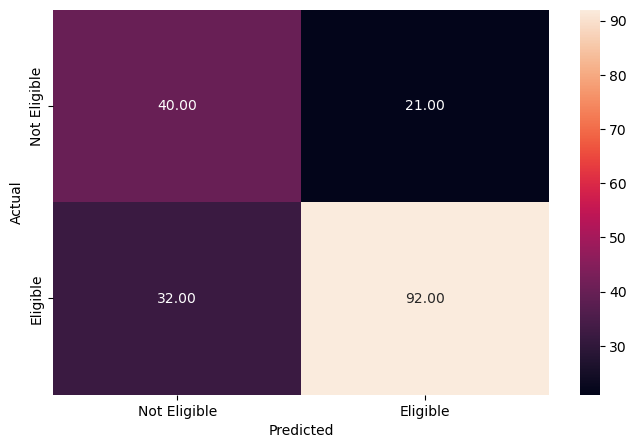

In [73]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1] > optimal_threshold1)

**Observations:____**
- The model recall score for class 0 has greatly improved and not stands at 66% however the precision has dropped significantly from what it was before.
- The model performs well on the training and test set correctly identifying more True and False positives

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN. We will perform the following steps for the same.**

- For every value of K (from 1 to 20), split the train set into new train and validation set (30 times)
- Scale the training data and validation data
- Take the average of the error on these train and the validation sets for each K
- Plot the average train vs the validation set error for all Ks 
- Choose a suitable K from the plot where the two errors are comparable

In [74]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        #let us scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.26395348837209304],
 2: [0.11195335276967931, 0.3406976744186046],
 3: [0.1576287657920311, 0.2484496124031007],
 4: [0.1625850340136054, 0.2616279069767442],
 5: [0.1835762876579204, 0.23875968992248062],
 6: [0.1848396501457726, 0.2430232558139536],
 7: [0.1923226433430515, 0.2193798449612404],
 8: [0.19067055393586008, 0.22868217054263568],
 9: [0.19883381924198254, 0.21162790697674422],
 10: [0.19951409135082607, 0.20852713178294577],
 11: [0.20252672497570465, 0.19961240310077522],
 12: [0.19883381924198254, 0.21007751937984498],
 13: [0.20680272108843542, 0.20193798449612413],
 14: [0.19640427599611276, 0.21240310077519384],
 15: [0.19931972789115646, 0.2054263565891473],
 16: [0.19562682215743446, 0.2104651162790698],
 17: [0.20145772594752184, 0.2089147286821706],
 18: [0.19737609329446063, 0.21046511627906986],
 19: [0.20136054421768712, 0.21666666666666673],
 20: [0.19659863945578232, 0.22248062015503883]}

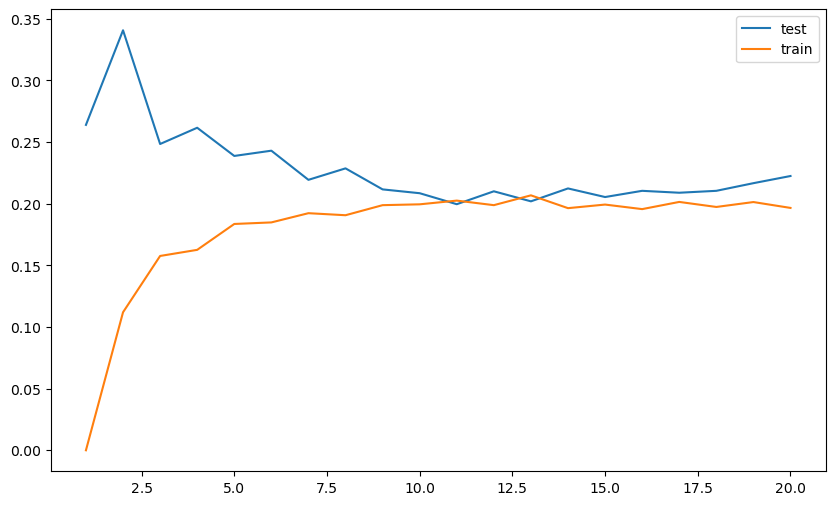

In [75]:
# Extracting k and the test error in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error error
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [76]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  #fit_transform the training data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) #transform the testing data

In [77]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

In [ ]:
#checking the performance of knn model
y_pred_train_knn = knn.predict(x_train)
metrics_score(y_train, y_pred_train_knn)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



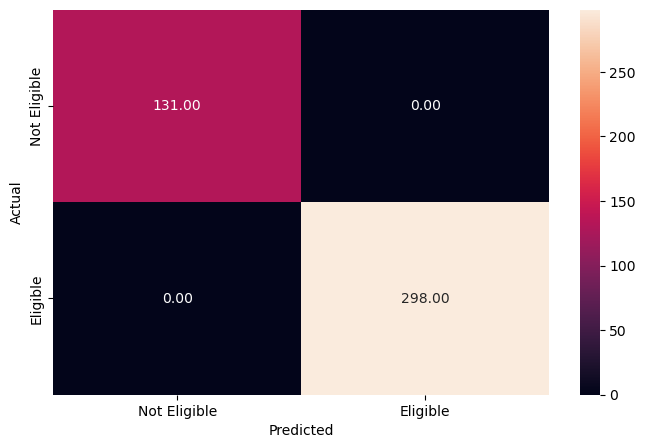

In [78]:
#predict on train data
y_pred_train_knn = knn.predict(X_train_scaled)# write your code here

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

**Observations:____**
- This model appears to be overfitting 
- Let's predict the test data and see it this is true

              precision    recall  f1-score   support

           0       0.60      0.30      0.40        61
           1       0.72      0.90      0.80       124

    accuracy                           0.70       185
   macro avg       0.66      0.60      0.60       185
weighted avg       0.68      0.70      0.67       185



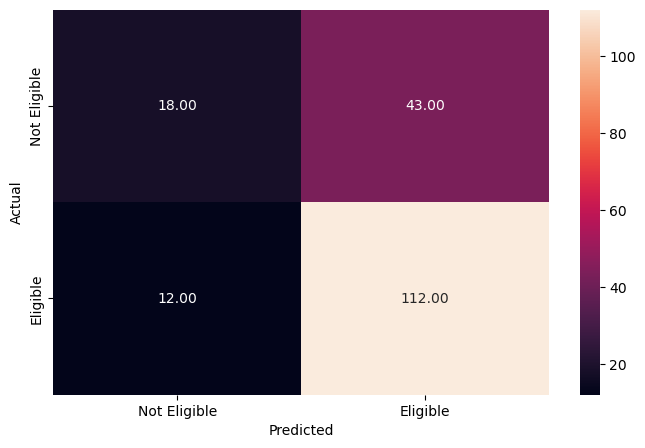

In [80]:
#predict on test data
y_pred_test_knn = knn.predict(X_test_scaled)# Write your code here

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

**Observation:____**
- As suspected the model is overfitting as the recall performance for class 0 is very poor compared to the train dataset


## Conclusion:

Write your conclusion here
- Between the Logistic model and the KNN model the better model is the logistic model as it has better generalization on the training and test data set and would therefore be the better classifier among the 2.

## Recommendations:

Write your recommendations here
- The most important factor for customer eligibility is a credit history that meets the required guidelines. Customers who has a good credit history would be more likely to be viewed as eligible for a loan.
- Customers applying for a loan for properties in semi-urban areas area more likely to be viewed as eligible than customers with properties in urban and rural areas. This could be because of other factors like interest rates or the type of property itself. More information is needed to make further conclusions.
- Customers who are married with 2 - 3 children are more likely to be viewed as eligible. It can be that applicants with families would be less likely to default on their loan therefore would be safer to loan to.
- Customers with lesser incomes would be less likely to be viewed as eligible for a loan. This is likely because there is a higher risk of defaulting with customers who has less money.
- Self employed customers are less likely to get a loan. Self employment is easily affected by economic changes and that therefore becomes an increased risk.
- Customers taking out little loan amounts with a short loan maturity term are less likely to get a loan. For a business angle, such loans would be less profitable that larger loans with a longer maturity term.